In [1]:
sea.scatterplot(x='x1', y='x2', size = "facility", sizes = {0 : 10, 1 : 200}, 
                hue='Author', data=temp)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

NameError: name 'sea' is not defined

## Dummy Data

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sea # for plot styling
import numpy as np
import pandas as pd
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans

In [4]:
import ortools
from ortools.linear_solver import pywraplp
from ortools.graph import pywrapgraph

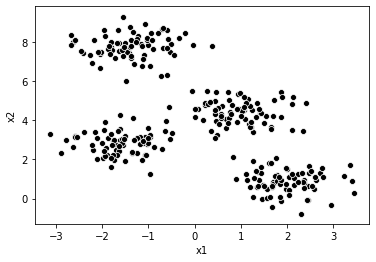

In [5]:
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)


df = pd.DataFrame()
df["x1"] = X[:,0]
df["x2"] = X[:,1]
df["true"] = y_true



sea.scatterplot(x = "x1", y = "x2", data = df, color = "black")


In [6]:
clusters = pd.read_csv("clusters2.csv")
clusters["X"].astype(float)
clusters["Y"].astype(float)
clusters.head()

,X,Y,Color
0,1.155213,5.099619,0
1,1.413724,4.381177,0
2,1.242588,4.503992,0
3,0.453792,3.956478,1
4,1.069239,4.530685,1


## Original Data

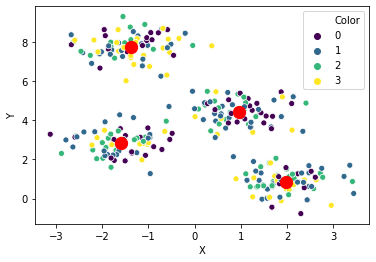

In [7]:
sea.scatterplot(x = "X", y = "Y", data = clusters, hue = "Color", palette = "viridis")
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=150);

## Without regard to color of points

In [8]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

In [9]:
kmeans.score(X)

-212.00599621083524

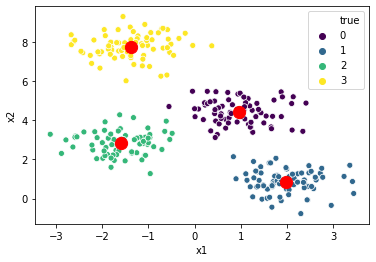

In [10]:
sea.scatterplot(x = "x1", y = "x2", hue = "true", data = df, palette = "viridis")
#plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=150);

## Running our algo

In [11]:
vectors = []
for i in range(len(clusters["X"])): 
    sublist = []
    sublist.append(float(clusters["X"][i]))
    sublist.append(float(clusters["Y"][i]))
    vectors.append(sublist)

In [12]:
distances = np.zeros((300,300))
from scipy.spatial import distance

for i in range(len(vectors)):
    a = vectors[i]
    for j in range(len(vectors)):
        b = vectors[j]
        dst = distance.euclidean(a, b)
        distances[i,j] = dst

In [93]:
C = []
colors = clusters["Color"].unique()


for i in colors:
    df_sub = clusters[clusters["Color"] == i]
    C.append(df_sub.index.values)

In [14]:
a = 0.25
a_1 = np.ceil(1/a)
colors = 4
k = 25
lam = 2
n = 300

In [16]:
x = []
y = []
F_small = []

In [17]:
solver = pywraplp.Solver('LP',
                         pywraplp.Solver.GLOP_LINEAR_PROGRAMMING)

objective = solver.Objective()
for i in range(n):
    x.append([])
    y.append(solver.NumVar(0.0, 1.0,'y'))
    for j in range(n):
        x[i].append(solver.NumVar(0.0, 1.0,'x'))
        objective.SetCoefficient(x[i][j], 1)
objective.SetMaximization()

constraint = []
for j in range(n):
    constraint.append(solver.Constraint(1, 1))
    for i in range(n):
        constraint[j].SetCoefficient(x[i][j],1)

for i in range(n):
    for j in range(n):
        constraint.append(solver.Constraint(-solver.infinity(), 0))
        constraint[-1].SetCoefficient(x[i][j],1)
        constraint[-1].SetCoefficient(y[i],-1)

for i in range(n):
    constraint.append(solver.Constraint(-solver.infinity(), 0))
    constraint[-1].SetCoefficient(x[i][i],-1)
    constraint[-1].SetCoefficient(y[i],1)

for i in range(colors):
    constraint.append(solver.Constraint(-solver.infinity(), 0))
    for j in range(n):
        constraint[-1].SetCoefficient(x[i][j],-a)
    if j in C[i]:
        constraint[-1].SetCoefficient(x[i][j],1-a)

for i in range(n):
    constraint.append(solver.Constraint(0, solver.infinity()))
    for j in range(n):
        constraint[-1].SetCoefficient(x[i][j],1)
        constraint[-1].SetCoefficient(y[i],-a_1)

constraint.append(solver.Constraint(0, k))
for i in range(n):
    constraint[-1].SetCoefficient(y[i],1)

for i in range(n):
    for j in range(n):
        if distances[i,j] > lam:
            constraint.append(solver.Constraint(0, 0))
            constraint[-1].SetCoefficient(x[i][j],1)

status = solver.Solve()
status == solver.OPTIMAL

True

In [18]:
X_sol = np.zeros((n,n))
Y_sol = []
for i in range(n): 
    Y_sol.append(y[i].solution_value())
    for j in range(n):
        X_sol[i,j] = x[i][j].solution_value()

In [19]:
z = 0
v = 0
for i in range(n):
    z += Y_sol[i]
    for j in range(n):
        v+= X_sol[i,j]
print(v,z)

300.0 18.0


In [20]:
F = []
for i in range(n):
    if Y_sol[i]>0:
        F.append(i)

In [21]:
def greedy_lambda(F, F_distances, lamb):
    removed = []
    Fcopy1 = F.copy()
    for i in F:
        if i not in removed:
            for j in F:
                if j not in removed:
                    if (i == j):
                        pass
                    elif (F_distances[i,j] < 2*lamb):
                        #print(F_distances[i,j])
                        Fcopy1.remove(j)
                        removed.append(j)
    return Fcopy1

In [22]:
dist = np.ones((n,n))*100000
for i in F:
    for j in F:
        if i != j:
            dist[i,j] = distances[i,j]

In [23]:
F

[6,
 12,
 17,
 25,
 35,
 51,
 72,
 104,
 105,
 106,
 152,
 159,
 214,
 215,
 289,
 297,
 298,
 299]

In [24]:
F_prime = greedy_lambda(F,distances,3)

In [25]:
F_prime = F

In [26]:
F_prime

[6,
 12,
 17,
 25,
 35,
 51,
 72,
 104,
 105,
 106,
 152,
 159,
 214,
 215,
 289,
 297,
 298,
 299]

In [27]:
dist1 = np.ones((n,n))*100000
for i in F:
    for j in F_prime:
        if i != j:
            dist1[i,j] = distances[i,j]

In [28]:
d = {}

for f in F:
    if f in F_prime: 
        if f in d:
            d[f].append(f)
        else:
            d[f] = []
            d[f].append(f)
    else:
        seen = 0
        for i in F_prime:
            if seen == 0 and dist1[f,i] == min(dist1[f]):
            #if dist1[f,i] < 20:
                if i in d:
                    d[i].append(f)
                else:
                    d[i] = []
                    d[i].append(f)
                seen = 1


In [29]:
d

{6: [6],
 12: [12],
 17: [17],
 25: [25],
 35: [35],
 51: [51],
 72: [72],
 104: [104],
 105: [105],
 106: [106],
 152: [152],
 159: [159],
 214: [214],
 215: [215],
 289: [289],
 297: [297],
 298: [298],
 299: [299]}

In [30]:
seen = set()
total = 0
x_new = np.zeros((n,n))
for j in range(n):
    for i in F_prime:
        for element in d[i]:
            seen.add(element)
            x_new[i,j] += X_sol[element,j]
            total += X_sol[element,j]
total

300.0

In [31]:
dict_enum = {}
num = 300
for i in F_prime:
    for c in np.arange(len(C)):
        dict_enum[(i,c)] = num
        num += 1

ind = len(F_prime)* 4 + 300
dict_enum['s'] = ind
dict_enum['t'] = ind+1

In [32]:
start_nodes = []
end_nodes = []
capacity = []

for j in range(n):
    start_nodes.append(int(ind))
    end_nodes.append(int(j))
    capacity.append(int(1))

arcindex = n
dict_arcs = {}

for color in range(len(C)):
    for index in C[color]:
        for i in F_prime:
            if x_new[i,index] > 0:
                start_nodes.append(int(index))
                dictind = dict_enum[(i,color)]
                end_nodes.append(int(dictind))
                capacity.append(int(1))
                dict_arcs[arcindex] = (index,(i,color))
                arcindex += 1
                
for i in F_prime:
    for color in range(len(C)):
        val = 0
        for index in C[color]:
            val += x_new[i,index]
        val = np.ceil(val)
        dictind = dict_enum[(i,color)]
        start_nodes.append(int(dictind))
        end_nodes.append(int(i+30000))
        capacity.append(int(val))

for i in F_prime:
    val = 0
    for j in range(n):
        val += x_new[i,j]
    val = np.ceil(val)
    start_nodes.append(int(i+30000))
    end_nodes.append(int(ind+1))
    capacity.append(int(val))


max_flow = pywrapgraph.SimpleMaxFlow()
for index in range(0, len(start_nodes)):
    max_flow.AddArcWithCapacity(start_nodes[index], end_nodes[index], capacity[index])

    
new_x1 = np.zeros((n,n))
if max_flow.Solve(ind, ind+1) == max_flow.OPTIMAL:
    for index in np.arange(n,arcindex):
        if max_flow.Flow(int(index)) > 0:
            j = dict_arcs[index][0]
            i = dict_arcs[index][1][0]
            col = dict_arcs[index][1][1]
            new_x1[i,j] = 1

In [33]:
eeee = 0
suma = {}
for i in F_prime:
    suma[i] = 0
    for j in range(n):
        suma[i]+= new_x1[i,j]
suma
sum(suma.values())

300.0

In [34]:
centroids = F_prime

In [35]:
listforc = {}
seen = []
for i in range(n):
    if sum(new_x1[i]) > 0:
        listforc[i] = [i]
        for j in range(n):
            if new_x1[i,j] > 0:
                listforc[i].append(j)
                seen.append(j)
#listforc

In [36]:
listforc

{6: [6, 6, 31, 36, 37, 39, 45, 47, 63, 69],
 12: [12, 12, 14, 23, 50, 53, 56],
 17: [17, 3, 17, 18, 21, 32, 67, 71, 73],
 25: [25, 0, 2, 8, 25, 40, 48, 49, 54, 57, 59, 60, 64, 66, 68, 74, 76],
 35: [35, 4, 5, 7, 9, 11, 34, 35, 44, 223],
 51: [51, 10, 13, 15, 16, 19, 24, 26, 27, 28, 29, 51, 52, 178],
 72: [72, 1, 20, 22, 33, 38, 41, 42, 46, 55, 58, 62, 65, 70, 72, 87],
 104: [104,
  82,
  89,
  92,
  98,
  100,
  101,
  104,
  112,
  113,
  116,
  126,
  130,
  132,
  133,
  136,
  139,
  140,
  141,
  142,
  143,
  144,
  148,
  149],
 105: [105,
  81,
  85,
  86,
  91,
  93,
  94,
  95,
  96,
  97,
  99,
  102,
  103,
  105,
  107,
  108,
  109,
  110,
  111,
  114,
  115,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  125,
  127,
  128,
  129,
  134,
  135,
  137,
  145,
  147],
 106: [106, 75, 77, 78, 79, 80, 83, 84, 88, 90, 106, 124, 131, 138, 146],
 152: [152,
  43,
  61,
  152,
  160,
  165,
  166,
  168,
  172,
  173,
  179,
  180,
  181,
  182,
  183,
  185,
  187,
  190,
 

In [37]:
dists = []
for i in listforc:
    for j in listforc[i]:
        dists.append(distances[i,j])
max(dists)
#for all distances, what was the maximum distance

1.9985488707375787

In [38]:
Fassign = {}

for i in listforc:
    Fassign[i] = {}
    for index in listforc[i]:
        for color in range(len(C)):
            if index in C[color]:
                if color in Fassign[i]:
                    Fassign[i][color] += 1
                else:
                    Fassign[i][color] = 1

In [39]:
##testing additive 2 violation

In [40]:
for i in listforc:
    for color in range(len(C)):
        if color in Fassign[i]:
            Fassign[i][color] = (Fassign[i][color] -2 )/ len(listforc[i])

In [41]:
for i in Fassign:
    for el in Fassign[i]:
        if Fassign[i][el] > 0.25:
            print(i, el,Fassign[i][el])

6 1 0.3
17 2 0.3333333333333333
25 1 0.29411764705882354
35 1 0.4
106 1 0.3333333333333333
152 0 0.2631578947368421
214 2 0.2857142857142857
214 1 0.3142857142857143
297 3 0.2777777777777778
297 1 0.2777777777777778
298 3 0.2857142857142857


In [42]:
Fassign

{6: {1: 0.3, 2: 0.1, 0: 0.0},
 12: {0: 0.14285714285714285, 2: -0.14285714285714285, 1: 0.14285714285714285},
 17: {2: 0.3333333333333333, 1: 0.0, 0: 0.0},
 25: {3: 0.058823529411764705,
  0: 0.11764705882352941,
  1: 0.29411764705882354,
  2: 0.058823529411764705},
 35: {1: 0.4, 0: 0.0, 2: -0.1, 3: -0.1},
 51: {1: 0.21428571428571427,
  0: 0.14285714285714285,
  2: 0.0,
  3: 0.07142857142857142},
 72: {0: 0.25, 2: 0.25, 3: -0.0625, 1: 0.0625},
 104: {2: 0.20833333333333334,
  3: 0.041666666666666664,
  0: 0.16666666666666666,
  1: 0.25},
 105: {2: 0.24324324324324326,
  1: 0.24324324324324326,
  3: 0.24324324324324326,
  0: 0.05405405405405406},
 106: {1: 0.3333333333333333, 2: 0.2, 3: 0.0, 0: -0.06666666666666667},
 152: {2: 0.05263157894736842,
  0: 0.2631578947368421,
  3: 0.10526315789473684,
  1: 0.15789473684210525},
 159: {2: 0.0, 0: 0.0, 1: 0.125, 3: -0.125},
 214: {2: 0.2857142857142857,
  0: 0.17142857142857143,
  1: 0.3142857142857143,
  3: 0.0},
 215: {1: 0.0,
  3: 0.22222

In [43]:
Fassign2 = {}

for i in listforc:
    Fassign2[i] = {}
    for index in listforc[i]:
        for color in range(len(C)):
            if index in C[color]:
                if color in Fassign2[i]:
                    Fassign2[i][color] += 1
                else:
                    Fassign2[i][color] = 1

for i in listforc:
    for color in range(len(C)):
        if color in Fassign2[i]:
            Fassign2[i][color] = (Fassign2[i][color])/ len(listforc[i])

In [44]:
for i in Fassign2:
    for el in Fassign2[i]:
        if Fassign2[i][el] > 0.25:
            print(i, el,Fassign2[i][el])

6 1 0.5
6 2 0.3
12 0 0.42857142857142855
12 1 0.42857142857142855
17 2 0.5555555555555556
25 1 0.4117647058823529
35 1 0.6
51 1 0.35714285714285715
51 0 0.2857142857142857
72 0 0.375
72 2 0.375
104 2 0.2916666666666667
104 1 0.3333333333333333
105 2 0.2972972972972973
105 1 0.2972972972972973
105 3 0.2972972972972973
106 1 0.4666666666666667
106 2 0.3333333333333333
152 0 0.3684210526315789
152 1 0.2631578947368421
159 1 0.375
214 2 0.34285714285714286
214 1 0.37142857142857144
215 3 0.3333333333333333
215 2 0.3333333333333333
289 3 0.5
297 3 0.3888888888888889
297 1 0.3888888888888889
298 3 0.35714285714285715
299 3 0.28
299 1 0.28


In [45]:
Fassign2

{6: {1: 0.5, 2: 0.3, 0: 0.2},
 12: {0: 0.42857142857142855, 2: 0.14285714285714285, 1: 0.42857142857142855},
 17: {2: 0.5555555555555556, 1: 0.2222222222222222, 0: 0.2222222222222222},
 25: {3: 0.17647058823529413,
  0: 0.23529411764705882,
  1: 0.4117647058823529,
  2: 0.17647058823529413},
 35: {1: 0.6, 0: 0.2, 2: 0.1, 3: 0.1},
 51: {1: 0.35714285714285715,
  0: 0.2857142857142857,
  2: 0.14285714285714285,
  3: 0.21428571428571427},
 72: {0: 0.375, 2: 0.375, 3: 0.0625, 1: 0.1875},
 104: {2: 0.2916666666666667, 3: 0.125, 0: 0.25, 1: 0.3333333333333333},
 105: {2: 0.2972972972972973,
  1: 0.2972972972972973,
  3: 0.2972972972972973,
  0: 0.10810810810810811},
 106: {1: 0.4666666666666667,
  2: 0.3333333333333333,
  3: 0.13333333333333333,
  0: 0.06666666666666667},
 152: {2: 0.15789473684210525,
  0: 0.3684210526315789,
  3: 0.21052631578947367,
  1: 0.2631578947368421},
 159: {2: 0.25, 0: 0.25, 1: 0.375, 3: 0.125},
 214: {2: 0.34285714285714286,
  0: 0.22857142857142856,
  1: 0.37142

In [ ]:
cluster_centers = list(Fassign.keys())
centers = []
for i in cluster_centers: 
    centers.append(vectors[i])

In [ ]:
centers = np.array(centers)

In [ ]:
sea.scatterplot(x = "X", y = "Y", hue = "Color", data = clusters, palette = "viridis")
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=100);

In [ ]:
centers

## K MEDOID

In [287]:
x = []
y = []
a = 0.5
a_1 = np.ceil(1/a)
colors = 4
k = 25
#lam = 15
n = 300
F_small = []


solver = pywraplp.Solver('LP',
                         pywraplp.Solver.GLOP_LINEAR_PROGRAMMING)

objective = solver.Objective()
for i in range(n):
    x.append([])
    y.append(solver.NumVar(0.0, 1.0,'y'))
    for j in range(n):
        x[i].append(solver.NumVar(0.0, 1.0,'x'))
        objective.SetCoefficient(x[i][j], distances[i][j])
objective.SetMinimization()

constraint = []
for j in range(n):
    constraint.append(solver.Constraint(1, 1))
    for i in range(n):
        constraint[j].SetCoefficient(x[i][j],1)

for i in range(n):
    for j in range(n):
        constraint.append(solver.Constraint(-solver.infinity(), 0))
        constraint[-1].SetCoefficient(x[i][j],1)
        constraint[-1].SetCoefficient(y[i],-1)

for i in range(n):
    constraint.append(solver.Constraint(-solver.infinity(), 0))
    constraint[-1].SetCoefficient(x[i][i],-1)
    constraint[-1].SetCoefficient(y[i],1)

for i in range(colors):
    constraint.append(solver.Constraint(-solver.infinity(), 0))
    for j in range(n):
        constraint[-1].SetCoefficient(x[i][j],-a)
    if j in C[i]:
        constraint[-1].SetCoefficient(x[i][j],1-a)

for i in range(n):
    constraint.append(solver.Constraint(0, solver.infinity()))
    for j in range(n):
        constraint[-1].SetCoefficient(x[i][j],1)
        constraint[-1].SetCoefficient(y[i],-a_1)

constraint.append(solver.Constraint(0, k))
for i in range(n):
    constraint[-1].SetCoefficient(y[i],1)

#for i in range(n):
#    for j in range(n):
#        if distances[i,j] > lam:
#            constraint.append(solver.Constraint(0, 0))
#            constraint[-1].SetCoefficient(x[i][j],1)

status = solver.Solve()
status == solver.OPTIMAL

True

In [288]:
solver.Objective().Value()

95.41843343057307

In [289]:
X_sol = np.zeros((n,n))
Y_sol = []
for i in range(n): 
    Y_sol.append(y[i].solution_value())
    for j in range(n):
        X_sol[i,j] = x[i][j].solution_value()

In [290]:
z = 0
v = 0
for i in range(n):
    z += Y_sol[i]
    for j in range(n):
        v+= X_sol[i,j]
print(v,z)

300.0 24.999999999999996


In [291]:
assign = {}
for i in range(n):
    if (Y_sol[i]==1):
        assign[i] = []
        for j in range(n):
            if (X_sol[i][j]==1):
                assign[i].append(j)

In [292]:
max_dist = -1
for i in list(assign.keys()):
    for j in assign[i]:
        if (distances[i][j] > max_dist):
            max_dist = distances[i][j]

In [293]:
max_dist

0.9647321545506117

In [294]:
R = []
for i in F:
    if i not in F_prime:
        R.append(i)

In [295]:
CA={}
max_f = 0
for i in R:
    CA[i] = 0
    W[i]=0
    for j in range(n):
        CA[i] += X_sol[i,j]*distances[i,j]
        W[i] += X_sol[i,j]  
    if W[i]/CA[i] > max_f:
        max_f = W[i]/CA[i]

C:\Users\simran\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


In [296]:
max_f

4.187896288228189

In [297]:
max_f*2*0.3045

2.550428839530967

In [298]:
F = []
for i in range(n):
    if Y_sol[i]>0:
        F.append(i)

In [299]:
def greedy_lambda(F, F_distances, lamb):
    removed = []
    Fcopy1 = F.copy()
    for i in F:
        if i not in removed:
            for j in F:
                if j not in removed:
                    if (i == j):
                        pass
                    elif (F_distances[i,j] < 2*lamb):
                        #print(F_distances[i,j])
                        Fcopy1.remove(j)
                        removed.append(j)
    return Fcopy1

In [300]:
dist = np.ones((n,n))*100000
for i in F:
    for j in F:
        if i != j:
            dist[i,j] = distances[i,j]

In [303]:
F_prime = greedy_lambda(F,distances,0.3)
len(F_prime)

25

In [304]:
F_prime
#cost of assigning each point to its closest of the 25 

costs = []
for i in range(n): 
    d = []
    for j in F_prime: 
        d.append(distances[i,j])
    costs.append(np.min(d))
        
np.sum(costs)

101.2014699059487

In [251]:
dist1 = np.ones((n,n))*100000
dist2 = np.zeros((n,n))
for i in F:
    for j in F_prime:
        if i != j:
            dist1[i,j] = distances[i,j]
for i in F_prime:
    for j in F_prime:
        if i!= j:
            dist2[i,j] = distances[i,j]

In [218]:
d = {}

for f in F:
    if f in F_prime: 
        if f in d:
            d[f].append(f)
        else:
            d[f] = []
            d[f].append(f)
    else:
        seen = 0
        for i in F_prime:
            if seen == 0 and dist1[f,i] == min(dist1[f]):
            #if dist1[f,i] < 20:
                if i in d:
                    d[i].append(f)
                else:
                    d[i] = []
                    d[i].append(f)
                seen = 1

In [219]:
seen = set()
total = 0
x_new = np.zeros((n,n))
for j in range(n):
    for i in F_prime:
        for element in d[i]:
            seen.add(element)
            x_new[i,j] += X_sol[element,j]
            total += X_sol[element,j]
total

300.0

In [220]:
dict_enum = {}
num = 300
for i in F_prime:
    for c in np.arange(len(C)):
        dict_enum[(i,c)] = num
        num += 1

ind = len(F_prime)* 4 + 300
dict_enum['s'] = ind
dict_enum['t'] = ind+1

In [221]:
start_nodes = []
end_nodes = []
capacity = []

for j in range(n):
    start_nodes.append(int(ind))
    end_nodes.append(int(j))
    capacity.append(int(1))

arcindex = n
dict_arcs = {}

for color in range(len(C)):
    for index in C[color]:
        for i in F_prime:
            if x_new[i,index] > 0:
                start_nodes.append(int(index))
                dictind = dict_enum[(i,color)]
                end_nodes.append(int(dictind))
                capacity.append(int(1))
                dict_arcs[arcindex] = (index,(i,color))
                arcindex += 1
                
for i in F_prime:
    for color in range(len(C)):
        val = 0
        for index in C[color]:
            val += x_new[i,index]
        val = np.ceil(val)
        dictind = dict_enum[(i,color)]
        start_nodes.append(int(dictind))
        end_nodes.append(int(i+10000))
        capacity.append(int(val))

for i in F_prime:
    val = 0
    for j in range(n):
        val += x_new[i,j]
    val = np.ceil(val)
    start_nodes.append(int(i+10000))
    end_nodes.append(int(ind+1))
    capacity.append(int(val))


max_flow = pywrapgraph.SimpleMaxFlow()
for index in range(0, len(start_nodes)):
    max_flow.AddArcWithCapacity(start_nodes[index], end_nodes[index], capacity[index])

    
new_x1 = np.zeros((n,n))
if max_flow.Solve(ind, ind+1) == max_flow.OPTIMAL:
    for index in np.arange(n,arcindex):
        if max_flow.Flow(int(index)) > 0:
            j = dict_arcs[index][0]
            i = dict_arcs[index][1][0]
            col = dict_arcs[index][1][1]
            new_x1[i,j] = 1

In [222]:
eeee = 0
suma = {}
for i in F_prime:
    suma[i] = 0
    for j in range(n):
        suma[i]+= new_x1[i,j]
suma

{4: 15.0,
 16: 18.0,
 17: 3.0,
 51: 15.0,
 56: 9.0,
 63: 15.0,
 80: 12.0,
 85: 12.0,
 92: 9.0,
 103: 24.0,
 105: 10.0,
 112: 1.0,
 127: 7.0,
 153: 10.0,
 165: 18.0,
 172: 23.0,
 190: 14.0,
 193: 0.0,
 209: 10.0,
 228: 10.0,
 232: 10.0,
 233: 11.0,
 247: 23.0,
 257: 8.0,
 285: 13.0}

In [223]:
tot = 0
for i in range(n):
    for j in range(n):
        tot += new_x1[i,j]
tot

300.0

In [224]:
listforc = {}
seen = []
obj_cost = 0
for i in range(n):
    if sum(new_x1[i]) > 0:
        listforc[i] = []
        for j in range(n):
            if new_x1[i,j] > 0:
                listforc[i].append(j)
                obj_cost += distances[i,j]
                seen.append(j)
obj_cost

114.88169400395907

In [225]:
maxval = np.max(dist2)
print(maxval)

9.362436877870177


In [71]:
gamma_h = maxval/2
print(gamma_h)

4.758063433846053


In [ ]:
distances

In [ ]:
F_prime

In [ ]:
#assign every point to its closest center in F_prime

f_prime_dict = {i:[] for i in F_prime}
point_to_vector = {i:vectors[i] for i in range(len(vectors))}

for i in range(len(vectors)): 
    d_ = []
    for j in F_prime:
        d_.append(distances[i,j])
    ind = np.argmin(d_)
    assignment = F_prime[ind]
    f_prime_dict[F_prime[ind]].append(i) 
    
    
        

In [ ]:
f_prime_dict

In [ ]:
##sum distances